# Fundamentals of Supervised Learning

This notebook was written with the desire to soldify machine learning knowledge learned from
* **CS170** --> Introduction to Machine Learning & Data Mining by Christian Shelton
* **DeepLearning.ai & Stanford ONLINE** --> Machine Learning Specialization by Andrew Ng

In [42]:
# all modules used in this notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# personal color pallete
c_ = {
    'red': '#ff6188',
    'orange': '#fc9867',
    'yellow': '#ffd866',
    'green': '#a8dd76',
    'blue': '#78dce8',
    'purple': '#ac9df2',
    'grey': '#2c2a2e',
    'white': '#fcfcfa',
    'black': '#211f22' 
}

# global params
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.facecolor'] = c_['black']
plt.rcParams['axes.facecolor'] = c_['black']
plt.rcParams['text.color'] = c_['white']
plt.rcParams['axes.labelcolor'] = c_['white']
plt.rcParams['xtick.color'] = c_['white']
plt.rcParams['ytick.color'] = c_['white']

## Data Generation

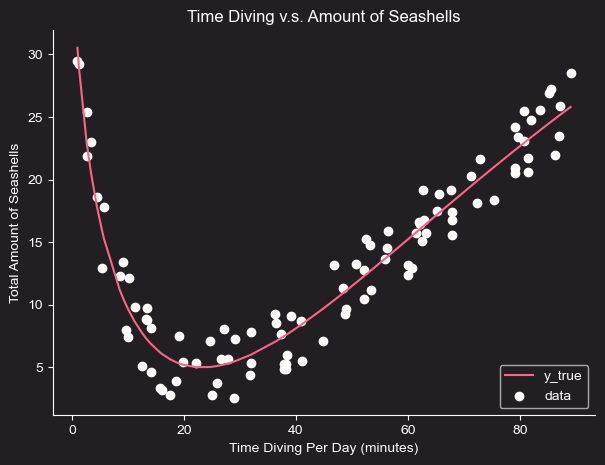

In [43]:
np.random.seed(1)
n_samples = 100
# sample data
x_sample = np.round(np.sort(np.random.uniform(low=1, high=90, size=n_samples)), 2)
y_noise = np.random.uniform(low=-3, high=3, size=n_samples)
y_true = -20*np.sin(x_sample**(1/3) + 5) + 25
y_sample = y_true + y_noise
# graph of data
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_sample, y_true, c=c_['red'], label='y_true')
ax.scatter(x_sample, y_sample, c=c_['white'], label='data')
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.set_title('Time Diving v.s. Amount of Seashells')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right');

## Linear Regression

The hypothesis function is:
$$f(\vec{x}) = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$
$$f(\vec{x}) = \vec{w}^T\vec{x} + b$$

To simplify code implementation of linear regression, $w_0 = b$ is included in our weight vector. Now $f(\vec{x})$ is
$$f(\vec{x}) = w_0x_0 + w_1x_1 + w_2x_2 ... + w_nx_n$$
Every example vector will have a scalar $1$ (representing $x_0$) in the first dimension to accomdate for the bias unit $w_0$


In [44]:
def linear_predict(X, w):
    return X @ w

In [45]:
X = np.vstack([np.ones(x_sample.shape[0]), x_sample]).T
y = y_sample

w_rand = [0, 0.87]
# example prediction with 0th example
print('example:')
print(f'[px_0, x_1] -> {X[0]}')
print(f'[bias, weight] -> {w_rand}')
print(f'f(x_0) = {linear_predict(X[0], w_rand)}')

example:
[px_0, x_1] -> [1.   1.01]
[bias, weight] -> [0, 0.87]
f(x_0) = 0.8787


### Measurement of Error
The **loss** (squared error) for each example is defined as
$$l(w,\vec{x_i}) = (f(\vec{x_i}) - y_i)^2$$
where $f(\vec{x_i})$ is the predicted outcome made by the model and $y_i$ is the observed outcome.

The **cost** function (mean squared error) is defined as
$$L(w,X) = \frac{1}{2m}\sum^{m - 1}_{i = 0}l(w,\vec{x_i})$$
The constant $2m$ is used instead of $m$ for a cleaner partial derivative function when implementating gradient descent. The affect of dividing by $2$ does not impact the algorithm's inference accuracy.

In [ ]:
# loss function (squared error)
def loss_se(y_hat, y):
    return (y_hat - y)**2

# cost function (mean squared error)
def cost_mse(y_hat, y):
    return np.sum((y_hat - y)**2)/(2*y.shape[0])

cost over all examples: 1.8042248271605508


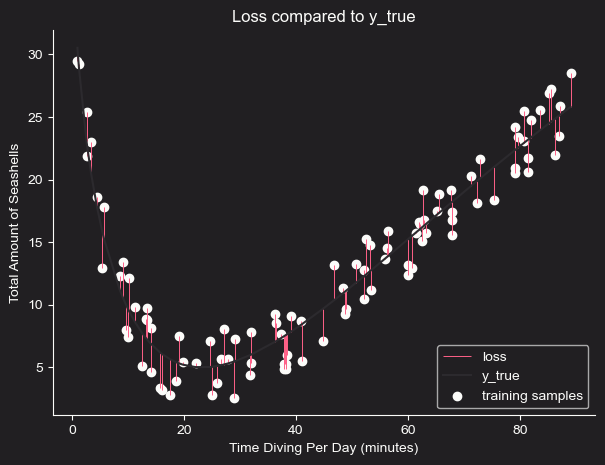

In [47]:
fig, ax = plt.subplots(figsize=(7,5))

mm = np.sort(np.vstack([y_sample, y_true]), axis=0)
ax.vlines(x=x_sample, ymin=mm[0], ymax=mm[1], color=c_['red'], label='loss', linewidth=0.7)
ax.plot(x_sample, y_true, c=c_['grey'], label='y_true')
ax.scatter(x_sample, y_sample, c=c_['white'], label='training samples')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.set_title('Loss compared to y_true')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right')
ax.legend(loc='lower right')

print(f'cost over all examples: {cost_mse(y_true, y_sample)}');

### Splitting Dataset

In [48]:
def train_test_split(X, y, p_train=0.6, get_index=False):
    n = X.shape[0]
    sample_indicies = np.arange(0, n)
    
    train_mask = np.random.choice(sample_indicies, size=int(p_train * n), replace=False)
    test_mask = sample_indicies[~np.isin(sample_indicies, train_mask)]
    
    if get_index:
        return X[train_mask], y[train_mask], X[test_mask], y[test_mask], train_mask, test_mask
    
    return X[train_mask], y[train_mask], X[test_mask], y[test_mask]

In [49]:
np.random.seed(1)
X_train, y_train, _X, _y, train_mask, _mask = train_test_split(X, y, 0.6, get_index=True)
X_cv, y_cv, X_test, y_test, cv_mask, test_mask = train_test_split(_X, _y, 0.5, get_index=True)


Now we have our have separated the dataset into
* **training set**: to train our model
* **cross validation set**: to evaluate our model + adjust for best performance
* **test set**: see how model performs to unseen data

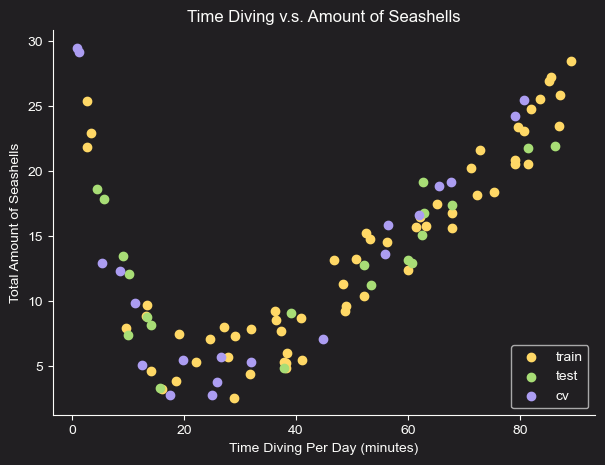

In [50]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:, 1], y_train, c=c_['yellow'], label='train')
ax.scatter(X_test[:, 1], y_test, c=c_['green'], label='test')
ax.scatter(X_cv[:, 1], y_cv, c=c_['purple'], label='cv')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.set_title('Time Diving v.s. Amount of Seashells')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right');
ax.legend(loc='lower right');

### Gradient Descent

Gradient Descent is an alogirthm that optimizes the weight values by minimizing total loss.

The cost function expanded is
$$L(w,X) = \frac{1}{2m}\sum^{m - 1}_{i = 0}(w_0x_{0}^{(i)} + w_1x_{1}^{(i)} + ... + w_nx_{n}^{(i)} - y^{(i)})^2$$

Gradient is defined as
$$\nabla\vec{L} = \begin{pmatrix}
\\
\frac{dL}{dw_0}\\\\
\frac{dL}{dw_1} \\\\
.\\
.\\
. \\\\
\frac{dL}{dw_n} \\ \\

\end{pmatrix}$$


Inorder to implement gradient descent, the the partial derivative w.r.t each variable must be defined.

$$\frac{dL}{dw_j} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})x_{j}^{(i)}$$
$$\frac{dL}{dw_0} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})$$



In [51]:
def linear_compute_gradient(X, y, w):
    m = X.shape[0]
    n = X.shape[1]
    
    y_hat = linear_predict(X, w)
    g_w = np.zeros(n)
    
    g_w[0] = np.sum(y_hat - y)/m
    
    for i in range(1, n):
        g_w[i] = np.sum((y_hat - y) * X[:, i])/m
    
    return g_w

The update rule for gradient descent is #TODO

In [52]:
def linear_gradient_descent(X, y, w, eta=0.01, threshold=0.005, max_iter = 1000):
    m = X.shape[0]
    
    delta_cost = math.inf
    y_hat = linear_predict(X, w)
    old_cost = cost_mse(y_hat, y)
    max_delta = 1e+20
    
    cost_list = [old_cost]
    grad_norm_list = [0]
    
    iterations = 0
    while delta_cost >= threshold:
        
        iterations += 1
        g_w = linear_compute_gradient(X, y, w)
        grad_norm_list.append(np.sqrt(np.sum(g_w**2)))
        w = w - eta*g_w
        
        y_hat = linear_predict(X, w)
        new_cost = cost_mse(y_hat, y) 
        
        delta_cost = np.abs(old_cost - new_cost)
        cost_list.append(new_cost)
        old_cost = new_cost
        
        if delta_cost > max_delta:
            print(f'error: delta cost reached over {max_delta}')
            break
    
    print(f'# of iterations: {iterations}')
    
    return (w, cost_list, grad_norm_list)

### Feature Scaling

In [53]:
class standard_scaler():
    def __init__(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
    
    def scale(self, X):
        return (X - self.mean)/self.std

In [54]:
X_train_scaled = X_train.copy()
scaler = standard_scaler(X_train_scaled[:, 1])
X_train_scaled[:, 1] = scaler.scale(X_train[:, 1])
w, cost_learned, grad_learned = linear_gradient_descent(X_train_scaled, y_train, w_rand)
print(f'weight values: {w}')

# of iterations: 301
weight values: [13.02919117  4.85204358]


In [55]:
X_train_trial = X_train.copy()
w_trial, cost_trial, grad_trial= linear_gradient_descent(X_train_trial, y_train, w_rand);
print(f'weight values: {w_trial}')

error: delta cost reached over 1e+20
# of iterations: 6
weight values: [5.70375106e+06 3.50602060e+08]


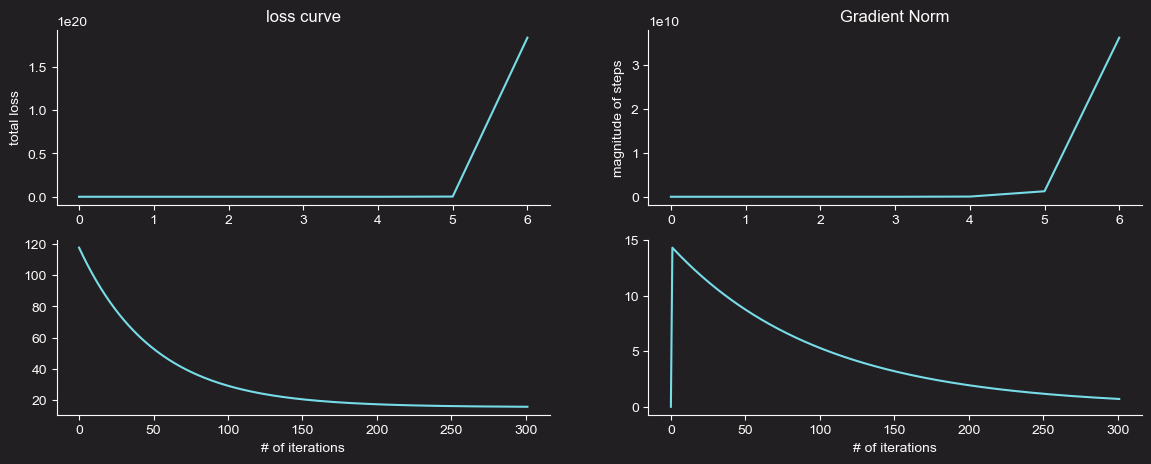

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(14,5))
n_iter = np.arange(len(cost_trial))
n1_iter = np.arange(len(cost_learned))
ax[0,0].plot(n_iter, cost_trial, c=c_['blue'])
ax[0,1].plot(n_iter, grad_trial, c=c_['blue'])
ax[1,0].plot(n1_iter, cost_learned, c=c_['blue'])
ax[1,1].plot(n1_iter, grad_learned, c=c_['blue'])

ax[0,0].set_title('loss curve')
ax[0,0].set_ylabel('total loss')
ax[0,0].set_ylabel('total loss')

ax[0,1].set_title('Gradient Norm')
ax[1,1].set_xlabel('# of iterations')
ax[1,0].set_xlabel('# of iterations')
ax[0,1].set_ylabel('magnitude of steps')

for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_['white'])
plt.show()

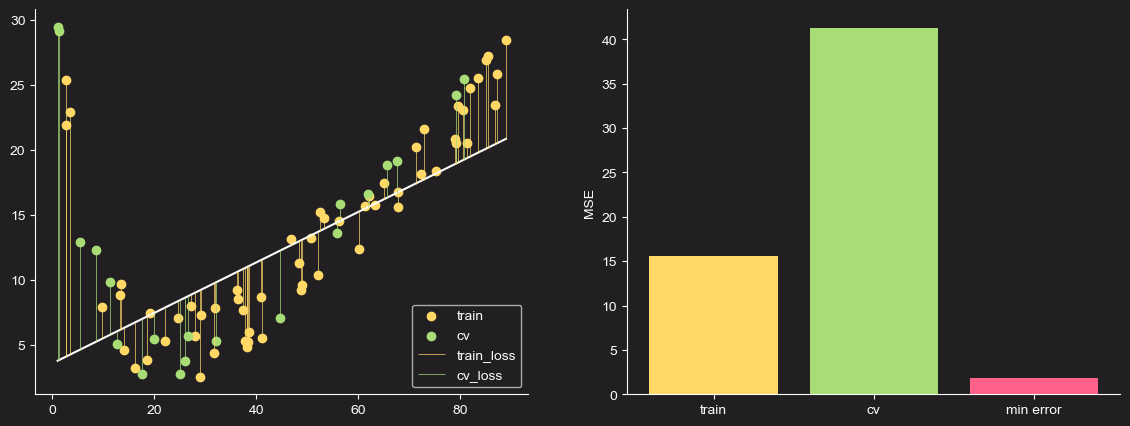

In [ ]:
X_scaled = X.copy()
X_scaled[:, 1] = scaler.scale(X[:, 1])

X_cv_scaled = X_cv.copy()
X_cv_scaled[:, 1] = scaler.scale(X_cv[:, 1])

y_pred_train = linear_predict(X_train_scaled, w)
y_pred_cv = linear_predict(X_cv_scaled, w)

train_err = np.sort(np.vstack([y_train, y_pred_train]), axis=0)
cv_err = np.sort(np.vstack([y_cv, y_pred_cv]), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(X[:, 1], linear_predict(X_scaled, w), c=c_['white'])
ax[0].vlines(x=X_train[:, 1], ymin=train_err[0], ymax=train_err[1], color=c_['yellow'], label='train_loss', linewidth=0.5)
ax[0].vlines(x=X_cv[:, 1], ymin=cv_err[0], ymax=cv_err[1], color=c_['green'], label='cv_loss', linewidth=0.5)

ax[1].bar(['train', 'cv', 'min error'],
          [cost_mse(y_train, y_pred_train), cost_mse(y_cv, y_pred_cv), cost_mse(y_train, y_true[train_mask])],
          color=[c_['yellow'], c_['green'], c_['red']])
ax[1].set_ylabel('MSE')

for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_['white'])

ax[0].legend(loc='lower right');

### Model Diagnostics & Tuning
* show overfitting to training data noise
* show bias vs variance graph with minimum variance using L_cv
* pick the degree two
* now try with test dataz

* increase degree by adding a variable --> x + ^2

In [99]:
np.random.rand( 3 + 1)

array([0.06703205, 0.81177151, 0.63629061, 0.77285043])

In [183]:
class LinearRegression():
    
    def __init__(self):
        self.weight = None # w_0 + w_1 + ... + w_n
        self.cost_list = None # L
        self.grad_list = None # gradient norm
        
        
    def fit(self, X, y, eta=0.01, max_iter=1000):
        
        m = X.shape[0]
        n = X.shape[1]
        
        X_new = np.hstack([np.ones(m).reshape(-1, 1), X])
        
        w_rand = np.random.rand(n + 1)
        w_rand[0] = 0
        self.weight = w_rand

        self._gradient_descent(X_new , y, eta=eta, threshold=0.005, max_iter=max_iter)
        

    def predict(self, X, dim=False):
        X_new = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X]) if X.shape[1] + 1 == self.weight.shape[0] else X.copy()
        print(X_new.shape, self.weight.shape) if dim else None
        return X_new @ self.weight


    def _compute_gradient(self, X, y):
        m = X.shape[0]
        n = X.shape[1]
        
        y_hat = self.predict(X)
        g_w = np.zeros(n)
        
        g_w[0] = np.sum(y_hat - y)/m
        
        for i in range(1, n):
            g_w[i] = np.sum((y_hat - y) * X[:, i])/m
        
        return g_w
    
    def _gradient_descent(self, X, y, eta, threshold, max_iter):
        delta_cost = math.inf
        y_hat = self.predict(X)
        old_cost = cost_mse(y_hat, y)
        max_delta = 1e+20
        
        self.cost_list = [old_cost]
        self.grad_list = [self._compute_gradient(X, y)]
        
        iterations = 0
        while delta_cost >= threshold:
            
            iterations += 1
            
            g_w = self._compute_gradient(X, y)
            self.grad_list.append(np.sqrt(np.sum(g_w**2)))
            self.weight =self.weight - eta*g_w
            
            y_hat = self.predict(X)
            new_cost = cost_mse(y_hat, y) 
            
            delta_cost = np.abs(old_cost - new_cost)
            self.cost_list.append(new_cost)
            old_cost = new_cost
            
            if delta_cost > max_delta:
                print(f'[error]: gradient descent diverged')
                break
        
        print(f'[complete]: # of iter: {iterations}')
    
    def _cost_mse(y_hat, y):
        return np.sum((y_hat - y)**2)/(2*y.shape[0])

In [ ]:
X2 = np.vstack([x_sample, x_sample**2]).T
X3 = np.vstack([X2.T, x_sample**3]).T
X4 = np.vstack([X3.T, x_sample**4]).T
X5 = np.vstack([X4.T, x_sample**4]).T

array([[1.01000000e+00, 1.02010000e+00, 1.03030100e+00],
       [1.26000000e+00, 1.58760000e+00, 2.00037600e+00],
       [2.63000000e+00, 6.91690000e+00, 1.81914470e+01],
       [2.72000000e+00, 7.39840000e+00, 2.01236480e+01],
       [3.44000000e+00, 1.18336000e+01, 4.07075840e+01],
       [4.48000000e+00, 2.00704000e+01, 8.99153920e+01],
       [5.45000000e+00, 2.97025000e+01, 1.61878625e+02],
       [5.75000000e+00, 3.30625000e+01, 1.90109375e+02],
       [8.57000000e+00, 7.34449000e+01, 6.29422793e+02],
       [9.22000000e+00, 8.50084000e+01, 7.83777448e+02],
       [9.75000000e+00, 9.50625000e+01, 9.26859375e+02],
       [1.01100000e+01, 1.02212100e+02, 1.03336433e+03],
       [1.01900000e+01, 1.03836100e+02, 1.05808986e+03],
       [1.12100000e+01, 1.25664100e+02, 1.40869456e+03],
       [1.25700000e+01, 1.58004900e+02, 1.98612159e+03],
       [1.32400000e+01, 1.75297600e+02, 2.32094022e+03],
       [1.34000000e+01, 1.79560000e+02, 2.40610400e+03],
       [1.34900000e+01, 1.81980

In [202]:
X4_train, X4_cv, X4_test = X4[train_mask], X4[cv_mask], X4[test_mask]

[complete]: # of iter: 346
[13.27107415 -0.33977462  1.69710713  2.4818353   2.17283481]
(60, 5) (5,)


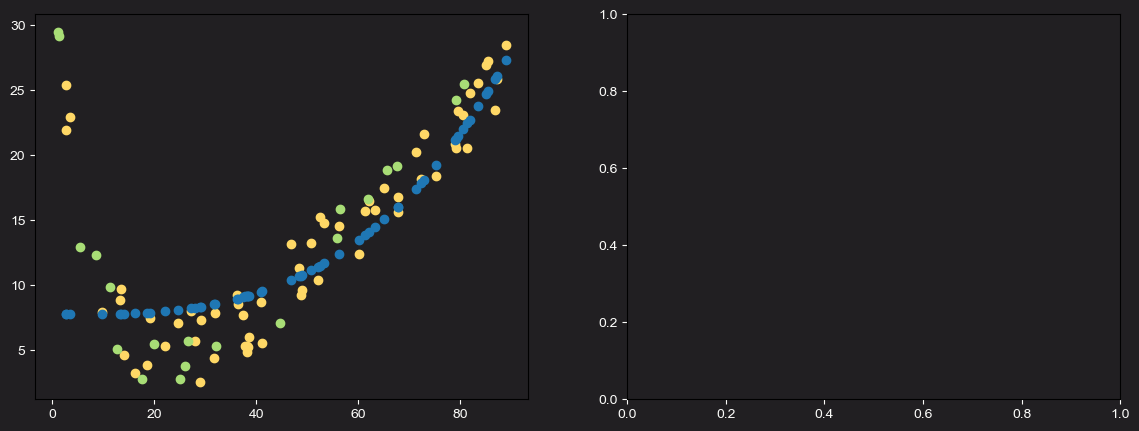

In [203]:
scaler4 = standard_scaler(X4_train)
X4_train_scaled = scaler4.scale(X4_train)
model4 = LinearRegression()
model4.fit(X4_train_scaled, y_train)
print(model4.weight)
y_train_hat = model4.predict(X4_train_scaled, dim=True)

fig, ax = plt.subplots(1, 2, figsize=(14 ,5))

ax[0].scatter(X_train[:, 1], y_train, c=c_['yellow'], label='train')
ax[0].scatter(X_cv[:, 1], y_cv, c=c_['green'], label='cv')
ax[0].scatter(X4_train[:, 0], y_train_hat)

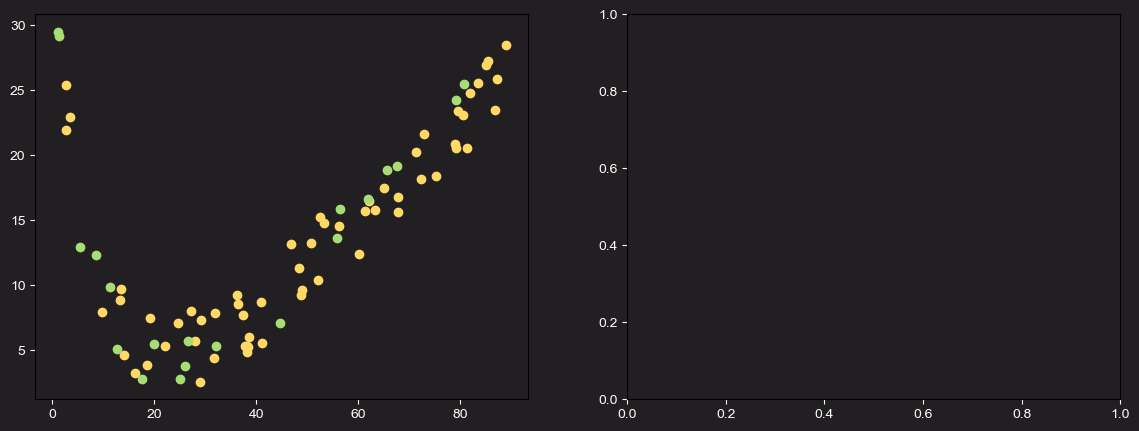

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].scatter(X_train[:, 1], y_train, c=c_['yellow'], label='train')
ax[0].scatter(X_cv[:, 1], y_cv, c=c_['green'], label='cv')

#### Bias vs. Variance Trade-off

#### Regularization

### Testing Model Performance

## Logistic Regression

* error analysis: look at a specific example that is being mis calssified
* classification metrics

hyperparameter tuning (cv_cost & train_cost) -> pick minimum cv_cost